### Importing Dependencies

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [24]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [25]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [26]:
processed_texts[:5]

['need advice appreciate people will will super aggressive control 6 month ago cheat girlfriend tell shortly feel like shit remind come get bad want stay thought linger way closure come thank advance hope y’ hate',
 'dear Magic Eye Bot hate wanna T',
 'teacher sub right wrong answer assignment clearly personal choice',
 'officially close 30 year age 10 goodbye r teenager fun today reach age subreddit long target good thing care cause mind 12',
 'sure royal family racism thing interesting you hear conspiracy kidnap child own cult shit wild surprised queen live']

In [27]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

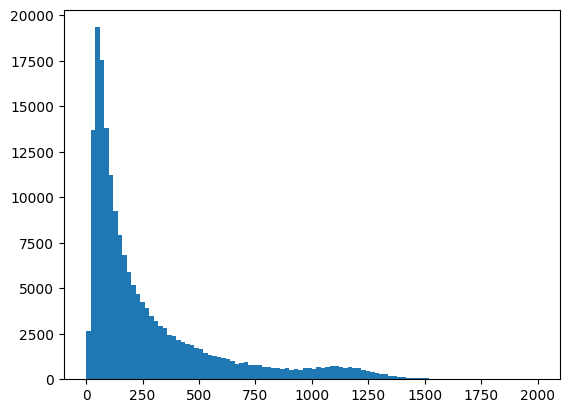

In [28]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [29]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [30]:
vectorized_texts = vectorize_layer(processed_texts)

In [31]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

In [32]:
vectorized_val_texts

<tf.Tensor: shape=(23208, 200), dtype=int64, numpy=
array([[  15,    1,  132, ...,    0,    0,    0],
       [ 339,   41,   23, ...,    0,    0,    0],
       [  12,    1,  466, ...,    0,    0,    0],
       ...,
       [ 227,    1, 2440, ...,    0,    0,    0],
       [ 766, 1770, 1919, ...,    0,    0,    0],
       [   3,   20,    3, ...,   49, 1188,    4]], dtype=int64)>

In [33]:
labels

array([0, 0, 0, ..., 0, 1, 0], dtype=int16)

#### Model 1

In [34]:
from keras_tuner import HyperParameters as hp
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(3001, 16),
    keras.layers.Bidirectional(keras.layers.GRU(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(20)),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [35]:
model.fit(vectorized_texts, labels, epochs=10, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Epoch 1/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 236s 40ms/step - accuracy: 0.8995 - loss: 0.2398 - val_accuracy: 0.9353 - val_loss: 0.1681
Epoch 2/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 228s 39ms/step - accuracy: 0.9430 - loss: 0.1509 - val_accuracy: 0.9399 - val_loss: 0.1578
Epoch 3/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 228s 39ms/step - accuracy: 0.9476 - loss: 0.1388 - val_accuracy: 0.9403 - val_loss: 0.1586
Epoch 4/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 228s 39ms/step - accuracy: 0.9518 - loss: 0.1287 - val_accuracy: 0.9401 - val_loss: 0.1560
Epoch 5/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 230s 40ms/step - accuracy: 0.9548 - loss: 0.1212 - val_accuracy: 0.9390 - val_loss: 0.1626
Epoch 6/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 229s 40ms/step - accuracy: 0.9569 - loss: 0.1155 - val_accuracy: 0.9396 - val_loss: 0.1601


##### Evaluating the Model

In [36]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

#### Saving the Model

In [37]:
best_model = model
with open('../models/gru_bi.pkl', 'wb') as fp:
    pickle.dump(model, fp)

In [38]:
best_model.summary()
_ = best_model.evaluate(vectorized_test_texts, test_labels)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 40)        │         4,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 40)             │         7,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,173 (703.80 KB)

 Trainable params: 60,057 (234.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 120,116 (469.21 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9406 - loss: 0.1523


In [39]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.0530
False Negative Rate: 0.0681
accuracy_score 0.940
precision_score 0.945
recall_score 0.932
f1_score 0.939


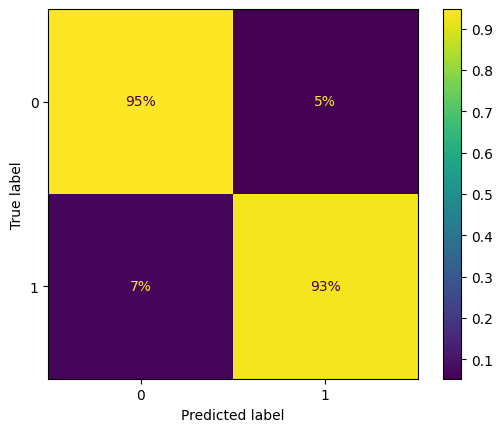

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()